The assignment was to take one or more datasets from http://stat-computing.org/dataexpo/2009/the-data.html and build a model that could accurately (85~) guess which flights would be delayed by 30 minutes or more based on information available when the aircraft took off.


## Importing code

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import math
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report


from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from timeit import default_timer as timer

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

## Uploading & subsetting data

In [4]:
# Upload 2006 dataset
airline_data_2006 = pd.read_csv('airline2006.csv')


In [52]:
# Upload 2007 dataset
airline_data_2007 = pd.read_csv('airline2007.csv')


In [5]:
# Sample smaller chunks of the 2006 dataset to speed up testing models
half_data_2006 = airline_data_2006.sample(frac=.5, random_state=2, axis=0)
quarter_data_2006 = airline_data_2006.sample(frac=.25, random_state=2, axis=0)
tenth_data_2006 = airline_data_2006.sample(frac=.1, random_state=2, axis=0)
hundreth_data_2006 = airline_data_2006.sample(frac=.01, random_state=2, axis=0)


#### Variable Descriptions:

1.	Year	1987-2008 
2.	Month	1-12
3.	DayofMonth	1-31
4.	DayOfWeek	1 (Monday) - 7 (Sunday)
5.	DepTime	actual departure time (local, hhmm)
6.	CRSDepTime	scheduled departure time (local, hhmm)
7.	ArrTime	actual arrival time (local, hhmm)
8.	CRSArrTime	scheduled arrival time (local, hhmm)
9.	UniqueCarrier	unique carrier code
10.	FlightNum	flight number
11.	TailNum	plane tail number
12.	ActualElapsedTime	in minutes
13.	CRSElapsedTime	in minutes
14.	AirTime	in minutes
15.	ArrDelay	arrival delay, in minutes
16.	DepDelay	departure delay, in minutes
17.	Origin	origin IATA airport code
18.	Dest	destination IATA airport code
19.	Distance	in miles
20.	TaxiIn	taxi in time, in minutes
21.	TaxiOut	taxi out time in minutes
22.	Cancelled	was the flight cancelled?
23.	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	Diverted	1 = yes, 0 = no
25.	CarrierDelay	in minutes
26.	WeatherDelay	in minutes
27.	NASDelay	in minutes
28.	SecurityDelay	in minutes
29.	LateAircraftDelay	in minutes

In [6]:
# create a report function that can be used for any model

def accuracy_report(testing_X, testing_Y, model):
    predictions = model.predict(testing_X)
    print('Model score:')
    print(model.score(testing_X, testing_Y))
    print(" ")
    print("Classification Report:")
    y_prediction = model.predict(testing_X)
    print(classification_report(testing_Y, y_prediction, target_names=['on-time', 'late']))
    auc = roc_auc_score(testing_Y.values, predictions)
    print('AUC score:%.3f'% auc)
    print(" ")
    print('Model cross-valuation:')
    print(sklearn.model_selection.cross_val_score(model, testing_X, testing_Y, cv = 5))
    return

## Cleaning data

In [7]:
# Create a working dataframe so that operations can be performed on any dataframe by switching out a single variable.
working_df = tenth_data_2006

# drop cancelation code (column) and any rows where the flight was canceled.
cancelled_flights = working_df.loc[working_df.Cancelled == 1]
working_df = working_df.drop('CancellationCode', axis=1)
working_df = working_df.drop('Cancelled', axis=1)
working_df = working_df.drop(cancelled_flights.index)

# Separate out UniqueCarrier, TailNum, FlightNum, Origin, and Dest 
# to remove non-numeric columns but also keep them available if needed later
working_nonnumeric = working_df[['UniqueCarrier','TailNum','Origin','Dest','FlightNum']]
working_df.drop(['UniqueCarrier','TailNum','Origin','Dest','FlightNum'], axis=1, inplace=True)

# Add in a binary feature for delays of over 30 minutes
working_df.loc[working_df.LateAircraftDelay >= 30, 'AircraftDelayed'] = 1
working_df.loc[working_df.LateAircraftDelay < 30, 'AircraftDelayed'] = 0

# Separate out LateAircraftDelay, TaxiIn, ArrDelay, ActualElapsedTime, ArrTime, and DepDelay, 
# due to them being variables that aren't known before a plane takes off.
cheat_variables = working_df[['LateAircraftDelay',
                              'TaxiIn', 
                              'ArrDelay', 
                              'ActualElapsedTime', 
                              'ArrTime', 
                              'AirTime',
                              'DepDelay']]

working_df.drop(['LateAircraftDelay', 'TaxiIn', 'ArrDelay', 'ActualElapsedTime', 'ArrTime', 'AirTime', 'DepDelay'], 
                axis=1, inplace=True)

# Drop out any remaining rows with NA in them.
working_df = working_df.dropna()
print(" ")

## Engineering features

In [8]:
# drop SecurityDelay, CRSElapsedTime, Distance, DayOfWeek, and Diverted,
# due to them having near-zero correlation with delays
working_df.drop(['SecurityDelay',
                 'CRSElapsedTime',
                 'Distance',
                 'DayOfWeek',
                 'Diverted'], axis=1, inplace=True)

# calculate PCA based on departure and expected arrival times (DepTime, CRSDepTime, CRSArrTime)
departure_arrival = working_df[['DepTime', 'CRSDepTime', 'CRSArrTime']]
pca = PCA(n_components=1)
departure_arrival_PCA = pca.fit_transform(departure_arrival)

# calculate PCA based on delays (DepDelay, TaxiOut, CarrierDelay, WeatherDelay, NASDelay)
delays = working_df[['TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay']]
pca = PCA(n_components=1)
delays_PCA = pca.fit_transform(delays)

# join the PCAs up with the working_df
working_df['departure_arrival_PCA'] = departure_arrival_PCA * -1   
working_df['delays_PCA'] = delays_PCA    

# create new **.5 and **2 features of relevant variables to see which ones have an impact on the models
#working_df['delays_PCA_squared'] = working_df.delays_PCA **2
working_df['delays_PCA_sqrt'] = working_df.delays_PCA **.5
#working_df['departure_PCA_squared'] = departure_arrival_PCA ** 2 
#working_df['departure_PCA_sqrt'] = departure_arrival_PCA ** .5
working_df['departure_discrepancy'] = working_df['DepTime'] - working_df['CRSDepTime']

# drop unmodified versions
working_df.drop(['delays_PCA'], axis=1, inplace=True)

# drop Year, Month, and DayofMonth
working_df.drop(['Year', 'Month', 'DayofMonth'], axis=1, inplace=True)

# Drop out any remaining rows with NA in them.
working_df = working_df.dropna()

In [9]:
# Build a PCA out of all of the base variables

all_variables = working_df[['DepTime', 
                            'CRSDepTime', 
                            'CRSArrTime', 
                            'TaxiOut', 
                            'CarrierDelay', 
                            'WeatherDelay', 
                            'NASDelay',
                            'departure_discrepancy']]
pca = PCA(n_components=5)
all_variables_PCA = pca.fit_transform(all_variables)

# Append the results to working_df
working_df['all_PCA_1'] = all_variables_PCA[:,0]    
working_df['all_PCA_2'] = all_variables_PCA[:,1]    
working_df['all_PCA_3'] = all_variables_PCA[:,2]    
working_df['all_PCA_4'] = all_variables_PCA[:,3]    
working_df['all_PCA_5'] = all_variables_PCA[:,4]

In [120]:
# After testing with SelectKBest to find the 10 highest performing features, drop the excess ones:

# working_df.drop(['TaxiOut', 'WeatherDelay', 'NASDelay', 'all_PCA_2', 'all_PCA_3'], axis=1, inplace=True)

# Note:  This significantly dropped the model's performance, without seeming to improve cross-valuation performance.
# In other words, pruning the feature-set in this way doesn't noticeably reduce overfitting, but does significantly
# reduce the model's capacity to predict delayed flights.


## Surveying the data with SelectKBest & visualisations

In [100]:
# Picking 5/10 SelectKBest features (replace k=5 with k=?? and delete the # from 6-10 to scale up)
X_best = SelectKBest(f_classif, k=10).fit_transform(
    working_df.drop(['AircraftDelayed'], axis=1), 
    working_df['AircraftDelayed'])
X_best_df = pd.DataFrame({
    'best_1':X_best[:,0],
    'best_2':X_best[:,1],
    'best_3':X_best[:,2],
    'best_4':X_best[:,3],
    'best_5':X_best[:,4],
    'best_6':X_best[:,5],
    'best_7':X_best[:,6],
    'best_8':X_best[:,7],
    'best_9':X_best[:,8],
    'best_10':X_best[:,9]
})

X_best_df.head(10)

,best_1,best_2,best_3,best_4,best_5,best_6,best_7,best_8,best_9,best_10
0,1150.000,1135.000,1240.000,15.000,-368.837,3.213,15.000,590.593,1.578,-27.050
1,1508.000,1400.000,1516.000,0.000,151.591,2.678,108.000,65.805,-57.101,39.266
2,1419.000,1252.000,1902.000,31.000,228.028,5.163,167.000,-22.754,20.110,-21.718
3,1840.000,1800.000,1925.000,40.000,808.584,6.077,40.000,-587.030,23.308,-7.059
4,2309.000,2150.000,26.000,18.000,232.697,4.014,159.000,22.792,-32.805,-16.014
5,1034.000,1015.000,1431.000,19.000,-400.964,4.355,19.000,616.846,-7.741,1.891
6,1417.000,1350.000,1615.000,8.000,123.565,1.924,67.000,93.319,-1.782,-31.636
7,630.000,621.000,740.000,9.000,-1254.543,2.443,9.000,1475.317,-11.456,-23.542
8,1939.000,1655.000,1913.000,0.000,777.203,3.543,284.000,-570.352,-86.900,85.393
9,1741.000,1700.000,1820.000,31.000,633.257,5.140,41.000,-411.868,19.201,-19.034


In [101]:
#working_df.describe()  
working_df.head(5)

,DepTime,CRSDepTime,CRSArrTime,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,AircraftDelayed,departure_arrival_PCA,delays_PCA_sqrt,departure_discrepancy,all_PCA_1,all_PCA_2,all_PCA_3,all_PCA_4,all_PCA_5
634606,1150.000,1135,1240,3,15,0,3,0.000,-368.837,3.213,15.000,590.593,22.310,34.278,1.578,-27.050
6655841,1508.000,1400,1516,43,0,0,83,0.000,151.591,2.678,108.000,65.805,-61.791,66.147,-57.101,39.266
4636729,1419.000,1252,1902,13,31,0,0,1.000,228.028,5.163,167.000,-22.754,-153.246,-340.250,20.110,-21.718
2549851,1840.000,1800,1925,26,40,0,3,0.000,808.584,6.077,40.000,-587.030,55.051,23.495,23.308,-7.059
239070,2309.000,2150,26,25,18,0,13,1.000,232.697,4.014,159.000,22.792,-11.938,1916.584,-32.805,-16.014


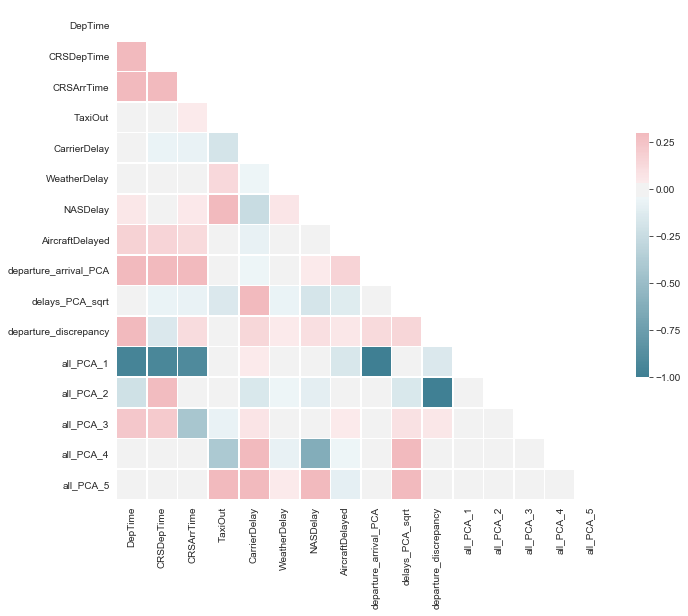

In [121]:
# Compute the correlation matrix
corr = working_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

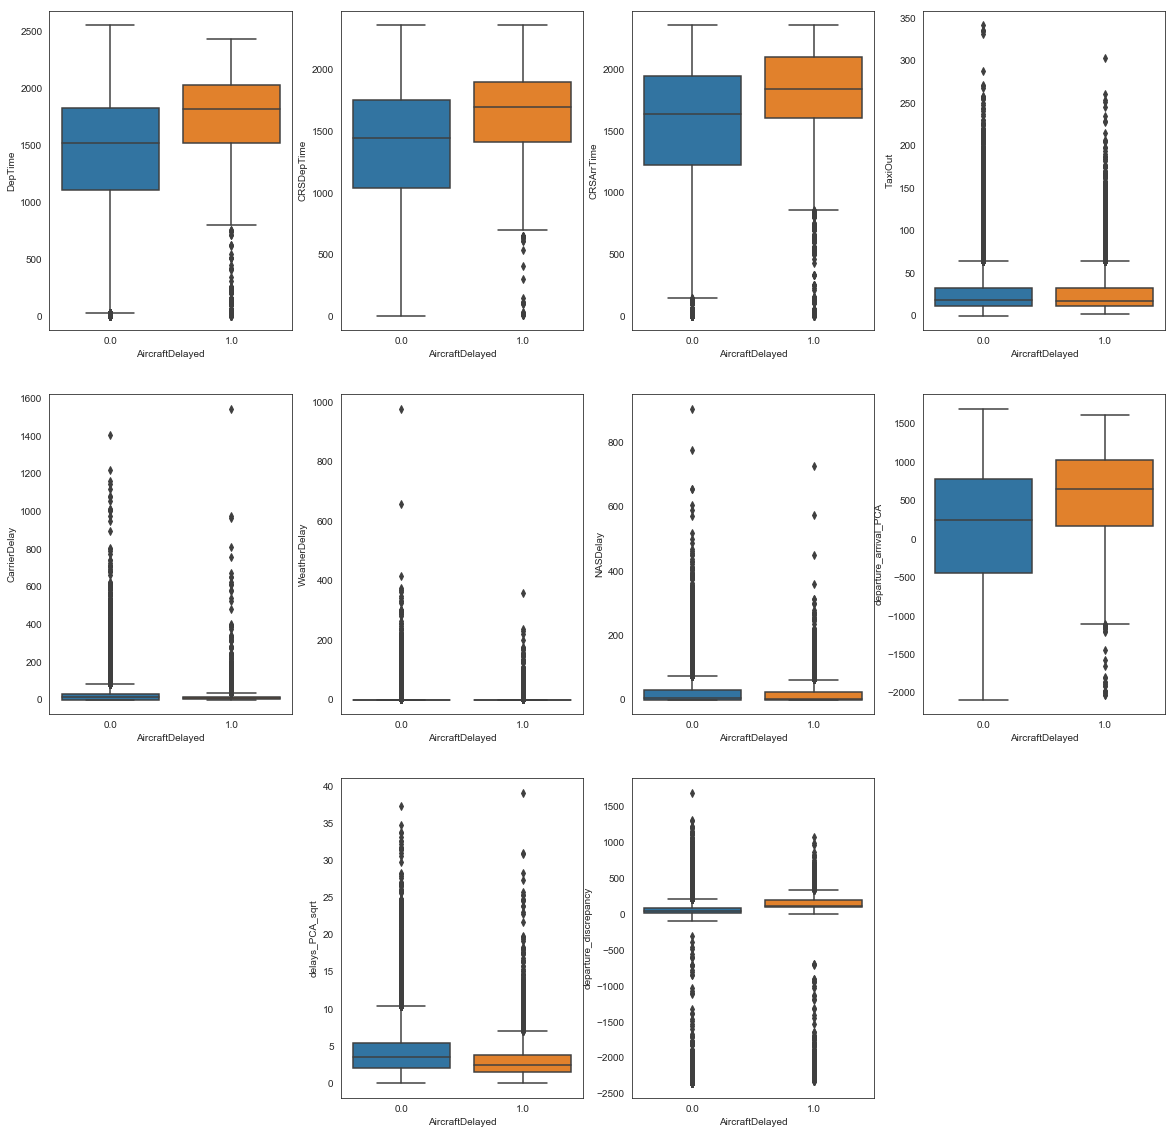

In [77]:
plt.figure(figsize=(20,20))

plt.subplot(341)
sns.boxplot(x = 'AircraftDelayed', y = 'DepTime', data = working_df)

plt.subplot(342)
sns.boxplot(x = 'AircraftDelayed', y = 'CRSDepTime', data = working_df)

plt.subplot(343)
sns.boxplot(x = 'AircraftDelayed', y = 'CRSArrTime', data = working_df)

plt.subplot(344)
sns.boxplot(x = 'AircraftDelayed', y = 'TaxiOut', data = working_df)

plt.subplot(345)
sns.boxplot(x = 'AircraftDelayed', y = 'CarrierDelay', data = working_df)

plt.subplot(346)
sns.boxplot(x = 'AircraftDelayed', y = 'WeatherDelay', data = working_df)

plt.subplot(347)
sns.boxplot(x = 'AircraftDelayed', y = 'NASDelay', data = working_df)

plt.subplot(348)
sns.boxplot(x = 'AircraftDelayed', y = 'departure_arrival_PCA', data = working_df)

plt.subplot(3,4,10)
sns.boxplot(x = 'AircraftDelayed', y = 'delays_PCA_sqrt', data = working_df)

plt.subplot(3,4,11)
sns.boxplot(x = 'AircraftDelayed', y = 'departure_discrepancy', data = working_df)

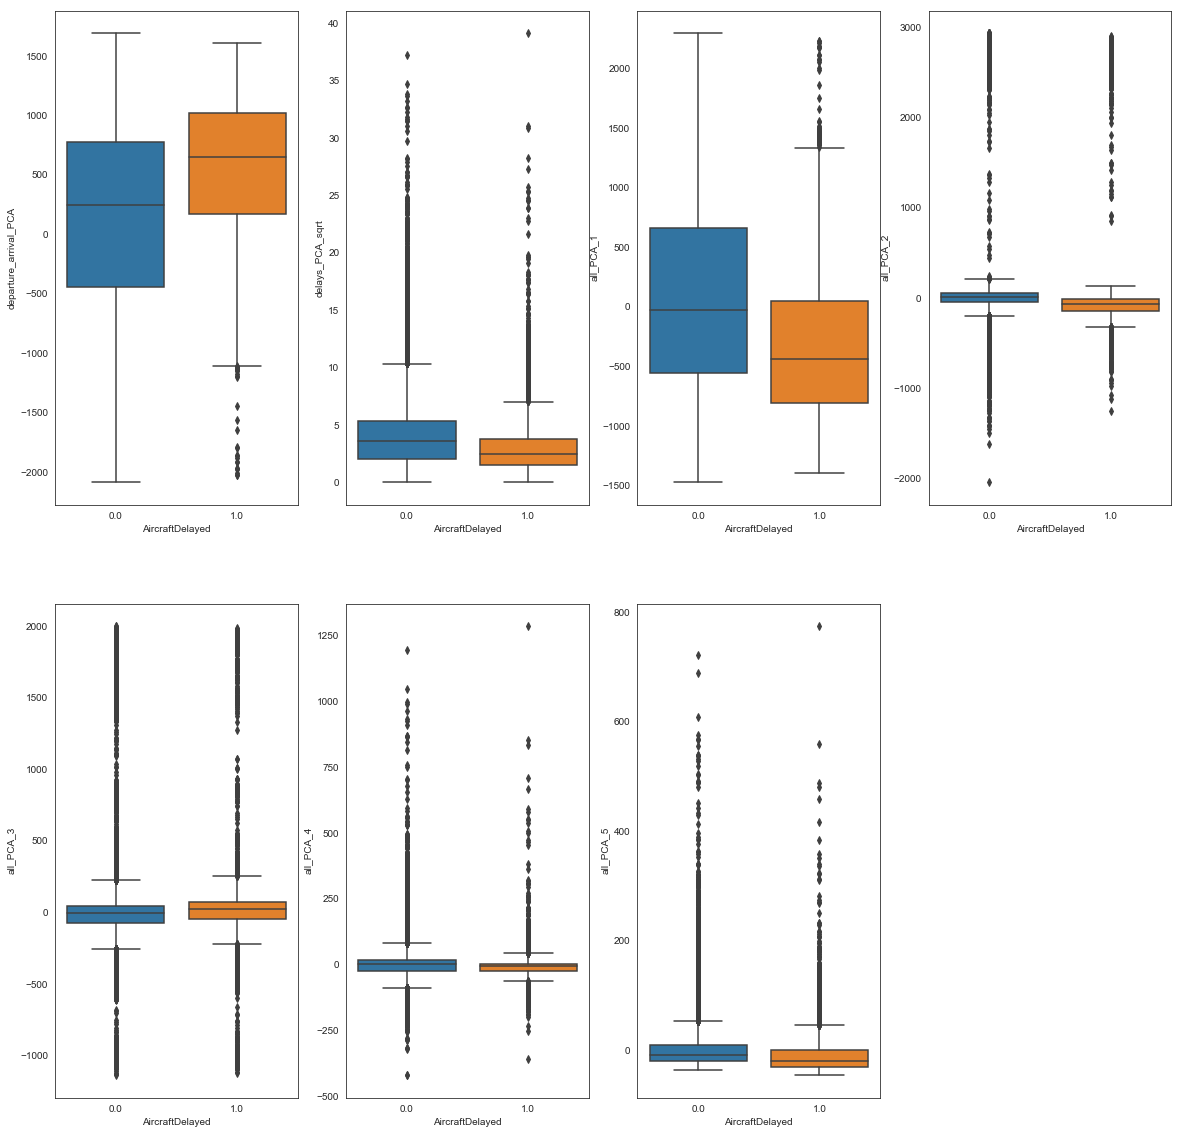

In [122]:
plt.figure(figsize=(20,20))

plt.subplot(241)
sns.boxplot(x = 'AircraftDelayed', y = 'departure_arrival_PCA', data = working_df)

plt.subplot(242)
sns.boxplot(x = 'AircraftDelayed', y = 'delays_PCA_sqrt', data = working_df)

plt.subplot(243)
sns.boxplot(x = 'AircraftDelayed', y = 'all_PCA_1', data = working_df)

plt.subplot(244)
sns.boxplot(x = 'AircraftDelayed', y = 'all_PCA_2', data = working_df)

plt.subplot(245)
sns.boxplot(x = 'AircraftDelayed', y = 'all_PCA_3', data = working_df)

plt.subplot(246)
sns.boxplot(x = 'AircraftDelayed', y = 'all_PCA_4', data = working_df)

plt.subplot(247)
sns.boxplot(x = 'AircraftDelayed', y = 'all_PCA_5', data = working_df)

## Preparing sample datasets for use in the model(s)

In [10]:
# create samples for training & testing
training_fraction = .8

training_X = working_df.sample(frac=training_fraction, random_state=10)
testing_X = working_df.drop(training_X.index)

# separate the Class feature out into Y datasets
training_Y = training_X['AircraftDelayed']
testing_Y = testing_X['AircraftDelayed']

# dropping the Class feature from the X datasets so that the model isn't able to cheat
training_X.drop('AircraftDelayed', axis=1, inplace=True)
testing_X.drop('AircraftDelayed', axis=1, inplace=True)
print(" ")

## Running an assortment of models to find the most successful

In [126]:
# Random Forest model
rfc = ensemble.RandomForestClassifier(n_estimators = 20)
rfc.fit(training_X,training_Y)
print('Random Forest results:')
print(' ')
accuracy_report(testing_X, testing_Y, rfc)

Random Forest results:
 
Model score:
0.9695774343456176
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.97      0.99      0.98     16416
        late       0.92      0.80      0.86      2090

   micro avg       0.97      0.97      0.97     18506
   macro avg       0.95      0.89      0.92     18506
weighted avg       0.97      0.97      0.97     18506

AUC score:0.894
 
Model cross-valuation:
[0.95867099 0.96379357 0.95974061 0.9610916  0.95974061]


In [11]:
# Decision Tree

dtree = tree.DecisionTreeClassifier()
dtree.fit(training_X,training_Y)
print('Decision Tree results:')
print(' ')
accuracy_report(testing_X, testing_Y, dtree)

Decision Tree results:
 
Model score:
0.9638495623041176
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.98      0.98      0.98     16416
        late       0.84      0.84      0.84      2090

   micro avg       0.96      0.96      0.96     18506
   macro avg       0.91      0.91      0.91     18506
weighted avg       0.96      0.96      0.96     18506

AUC score:0.911
 
Model cross-valuation:
[0.954349   0.95568765 0.95595785 0.95541745 0.9505539 ]


In [128]:
# Gradient Boosting Classifier

clf = ensemble.GradientBoostingClassifier()
clf.fit(training_X,training_Y)
print('GBC results:')
print(' ')
accuracy_report(testing_X, testing_Y, clf)


GBC results:
 
Model score:
0.9661190965092402
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.97      0.99      0.98     16416
        late       0.94      0.75      0.83      2090

   micro avg       0.97      0.97      0.97     18506
   macro avg       0.96      0.87      0.91     18506
weighted avg       0.97      0.97      0.96     18506

AUC score:0.870
 
Model cross-valuation:
[0.96245273 0.96190219 0.96001081 0.96649554 0.96379357]


In [ ]:
# SVM

svm = SVC(gamma = 'scale')
svm.fit(training_X,training_Y)
print('SVM results:')
print(' ')
accuracy_report(testing_X, testing_Y, svm)


In [130]:
# KNN

neighbors = KNeighborsClassifier()
neighbors.fit(training_X,training_Y)
print('KNN results:')
print(' ')
accuracy_report(testing_X, testing_Y, neighbors)

KNN results:
 
Model score:
0.9574192153896034
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.96      0.99      0.98     16416
        late       0.89      0.72      0.79      2090

   micro avg       0.96      0.96      0.96     18506
   macro avg       0.92      0.85      0.88     18506
weighted avg       0.96      0.96      0.96     18506

AUC score:0.852
 
Model cross-valuation:
[0.93787142 0.94650095 0.93542286 0.93650365 0.93488246]


In [131]:
# Logistic Regression

lr = LogisticRegression()
lr.fit(training_X,training_Y)
print('Logistic Regression results:')
print(' ')
accuracy_report(testing_X, testing_Y, lr)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression results:
 
Model score:
0.9018156273640981
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.90      1.00      0.95     16416
        late       0.98      0.13      0.23      2090

   micro avg       0.90      0.90      0.90     18506
   macro avg       0.94      0.57      0.59     18506
weighted avg       0.91      0.90      0.87     18506

AUC score:0.566
 
Model cross-valuation:


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[0.89816316 0.90759254 0.9019184  0.89759524 0.89408268]


In [132]:
# Naive Bayes

bnb = BernoulliNB()
bnb.fit(training_X,training_Y)
print('Naive Bayes results:')
print(' ')
accuracy_report(testing_X, testing_Y, bnb)

Naive Bayes results:
 
Model score:
0.8922511617853669
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.90      1.00      0.94     16416
        late       0.69      0.08      0.15      2090

   micro avg       0.89      0.89      0.89     18506
   macro avg       0.79      0.54      0.55     18506
weighted avg       0.87      0.89      0.85     18506

AUC score:0.539
 
Model cross-valuation:
[0.89222042 0.89516347 0.89057012 0.8921913  0.89111051]


### Model comparison:
RF is (by just a few percentage points) the best of the lot, getting a 98% l1-score for on-time arrivals and %86 l1-score for delayed flights.

DT is good (98%) at predicting on-time, and its late predictions get a l1-score of 84%.

GBC is good (98%) at predicting on-time, and its late predictions get a l1-score of 83%.

SVM has stalled out the python kernel in recent attempts to get it to run, though in prior (successful) experimental runs it produced extremely lackluster results, so it's not a terrible loss that exact numbers for it are unavailable. 

KNN is good (98%) at predicting on-time flights, but its late predictions get a l1-score of 79%.

LogR is mediocre (95%) at predicting on-time flights, and bad at predicting late ones (23%).

NB is even worse (94%) at predicting on-time flights and at predicting late ones (15%).

### Result:
RFC seems to perform the best, slightly edging out DT or GBC in terms of recall for late arrivals, and so I chose RFC to be the primary model for this assignment.



## Perform GridSearchCV to identify optimal parameters

In [25]:
# Gridsearch CV for the RFC algorithm

grid_param_RFC = {
    'max_features': [.5,.7,.9,'sqrt','log2'],
#    'max_depth': [None,1,2,3,4,5],
    'n_estimators' : [17,18,19,20,21,22]
}

grid_search_RFC = GridSearchCV(estimator = rfc,  
                              param_grid = grid_param_RFC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_RFC.fit(testing_X, testing_Y)
print('RFC recommended parameters:')
print(grid_search_RFC.best_params_)
print(' ')

RFC recommended parameters:
{'max_features': 0.9, 'n_estimators': 22}
 


### Successive results for Gridsearch CV:

1. {'max_depth': None, 'max_features': 0.7, 'n_estimators': 15}
2. {'max_depth': None, 'max_features': 0.9, 'n_estimators': 21}
3. {'max_depth': None, 'max_features': 0.7, 'n_estimators': 19}
4. {'max_features': 0.9, 'n_estimators': 22}  (As all previous recommendations had featured max_depth: None, it was removed from this run.)



### Result:
I've chosen to use the parameters [max_depth = None, max_features = 0.9, n_estimators = 21] for the final model. Due to the variability of GSCV results for this algorithm, there is likely to be a "better" result, but barring spending hours performing exhaustive GSCV tests to find it, I'm going to make an estimate based on these four runs and go with that.


## Set up 2007 data

In [138]:
# Reserving the 2006 working dataset for future use
working_df_2006 = working_df

In [134]:
# Treating the 2007 dataset with the same process as the 2006 dataset

# Create a working dataframe so that operations can be performed on any dataframe by switching out a single variable.
working_df = airline_data_2007

# drop cancelation code (column) and any rows where the flight was canceled.
cancelled_flights = working_df.loc[working_df.Cancelled == 1]
working_df = working_df.drop('CancellationCode', axis=1)
working_df = working_df.drop('Cancelled', axis=1)
working_df = working_df.drop(cancelled_flights.index)

# Separate out UniqueCarrier, TailNum, FlightNum, Origin, and Dest 
# to remove non-numeric columns but also keep them available if needed later
working_nonnumeric = working_df[['UniqueCarrier','TailNum','Origin','Dest','FlightNum']]
working_df.drop(['UniqueCarrier','TailNum','Origin','Dest','FlightNum'], axis=1, inplace=True)

# Add in a binary feature for delays of over 30 minutes
working_df.loc[working_df.LateAircraftDelay >= 30, 'AircraftDelayed'] = 1
working_df.loc[working_df.LateAircraftDelay < 30, 'AircraftDelayed'] = 0

# Separate out LateAircraftDelay, TaxiIn, ArrDelay, ActualElapsedTime, ArrTime, and DepDelay, 
# due to them being variables that aren't known before a plane takes off.
cheat_variables = working_df[['LateAircraftDelay',
                              'TaxiIn', 
                              'ArrDelay', 
                              'ActualElapsedTime', 
                              'ArrTime', 
                              'AirTime',
                              'DepDelay']]

working_df.drop(['LateAircraftDelay', 'TaxiIn', 'ArrDelay', 'ActualElapsedTime', 'ArrTime', 'AirTime', 'DepDelay'], 
                axis=1, inplace=True)

# Drop out any remaining rows with NA in them.
working_df = working_df.dropna()
print(" ")

# Cleaning up features, calculating PCA features, and engineering new ones

# drop SecurityDelay, CRSElapsedTime, Distance, DayOfWeek, and Diverted,
# due to them having near-zero correlation with delays
working_df.drop(['SecurityDelay',
                 'CRSElapsedTime',
                 'Distance',
                 'DayOfWeek',
                 'Diverted'], axis=1, inplace=True)

# calculate PCA based on departure and expected arrival times (DepTime, CRSDepTime, CRSArrTime)
departure_arrival = working_df[['DepTime', 'CRSDepTime', 'CRSArrTime']]
pca = PCA(n_components=1)
departure_arrival_PCA = pca.fit_transform(departure_arrival)

# calculate PCA based on delays (DepDelay, TaxiOut, CarrierDelay, WeatherDelay, NASDelay)
delays = working_df[['TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay']]
pca = PCA(n_components=1)
delays_PCA = pca.fit_transform(delays)

# join the PCAs up with the working_df
working_df['departure_arrival_PCA'] = departure_arrival_PCA * -1   
working_df['delays_PCA'] = delays_PCA    

# create new **.5 and **2 features of relevant variables to see which ones have an impact on the models
#working_df['delays_PCA_squared'] = working_df.delays_PCA **2
working_df['delays_PCA_sqrt'] = working_df.delays_PCA **.5
#working_df['departure_PCA_squared'] = departure_arrival_PCA ** 2 
#working_df['departure_PCA_sqrt'] = departure_arrival_PCA ** .5
working_df['departure_discrepancy'] = working_df['DepTime'] - working_df['CRSDepTime']

# drop unmodified versions
working_df.drop(['delays_PCA'], axis=1, inplace=True)

# drop Year, Month, and DayofMonth
working_df.drop(['Year', 'Month', 'DayofMonth'], axis=1, inplace=True)

# Drop out any remaining rows with NA in them.
working_df = working_df.dropna()

# Build a PCA out of all of the base variables

all_variables = working_df[['DepTime', 
                            'CRSDepTime', 
                            'CRSArrTime', 
                            'TaxiOut', 
                            'CarrierDelay', 
                            'WeatherDelay', 
                            'NASDelay',
                            'departure_discrepancy']]
pca = PCA(n_components=5)
all_variables_PCA = pca.fit_transform(all_variables)

# Append the results to working_df
working_df['all_PCA_1'] = all_variables_PCA[:,0]    
working_df['all_PCA_2'] = all_variables_PCA[:,1]    
working_df['all_PCA_3'] = all_variables_PCA[:,2]    
working_df['all_PCA_4'] = all_variables_PCA[:,3]    
working_df['all_PCA_5'] = all_variables_PCA[:,4]

working_df_2007 = working_df

## Set up 2006 and 2007 data into training & testing dataframes

In [139]:
# Creating Training and Testing variables to train on 2006 data and test on 2007 data

training_X = working_df_2006
testing_X = working_df_2007

# separate the Class feature out into Y datasets
training_Y = training_X['AircraftDelayed']
testing_Y = testing_X['AircraftDelayed']

# dropping the Class feature from the X datasets so that the model isn't able to cheat
training_X.drop('AircraftDelayed', axis=1, inplace=True)
testing_X.drop('AircraftDelayed', axis=1, inplace=True)
print(" ")

## Train the RF model on 2006 data and test it on 2007 data

In [140]:
# Random Forest model, using 2006 data to train and 2007 data to test

rfc = ensemble.RandomForestClassifier(max_depth = None, max_features = 0.9, n_estimators = 21)
rfc.fit(training_X,training_Y)
print('Random Forest results:')
print(' ')
accuracy_report(testing_X, testing_Y, rfc)

Random Forest results:
 
Model score:
0.9764745129436883
 
Classification Report:
              precision    recall  f1-score   support

     on-time       0.99      0.99      0.99    793937
        late       0.89      0.91      0.90    105343

   micro avg       0.98      0.98      0.98    899280
   macro avg       0.94      0.95      0.94    899280
weighted avg       0.98      0.98      0.98    899280

AUC score:0.948
 
Model cross-valuation:
[0.9805401  0.9794559  0.97858843 0.97978371 0.9776987 ]


## Conclusion

After testing seven different models, Random Forest, Decision Tree, and Gradient Boosting Classifier proved to be the most effective, with Random Forest eaking out a slight lead over DT & GBC.  

Repeated testing with Gridsearch CV revealed a variable optimal parameter space (shifting between tests even when given identical parameters to choose from), with the optimum range being around max_features = .9 and n_estimators =21.  

Feature selection was facilitated by visualizations, trial and error, and SelectKBest, all of which consistently pointed to CRS departure and arrival times as critical to correctly estimating delays.  Further experimentation with removing different resulted in the inclusion of all engineered features, as none resulted in significant overfitting while the removal of any of them was detrimental to the model's accuracy (sometimes significantly so).

In the end, the model achieved an accuracy score of %97.6, with a minimal amount of overfitting (based on the cross-valuation scores) and a reasonably high degree of accuracy for both on-time (%99) and late arrivals (90%).

The model could likely be optimized further, given more time and feature engineering, and/or a more refined model list, but for now a %90 correct prediction of delays (f1-score) seems a reasonable result.